In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 934.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [ ]:
plot_settings = {
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [ ]:
data = get_data("airquality")

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [ ]:
data = data.iloc[-720:]
data["index"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.drop(columns=["Date", "Time"], inplace=True)
data.replace(-200, np.nan, inplace=True)
target = "CO(GT)"

In [ ]:
skip_vars = ['NMHC(GT)', 'AH']
data.drop(columns=skip_vars, inplace=True)

In [ ]:
data_uni = data.copy()
data_uni.set_index("index", inplace=True)
data_uni = data_uni[target]

In [ ]:
exp_uni = TSForecastingExperiment()
exp_uni.setup(
    data=data_uni, fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=plot_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,2.8%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
model_uni = exp_uni.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2005-03-27 14:00,1.5606,1.4904,1.1466,1.6039,0.6598,1.0119,-1.7616
1,2005-03-29 14:00,2.5919,1.9767,1.8655,2.1105,1.4991,0.7419,-2.7317
2,2005-03-31 14:00,1.4605,1.1539,1.0401,1.2124,1.2860,1.2780,-6.2314
Mean,NaT,1.8710,1.5403,1.3507,1.6422,1.1483,1.0106,-3.5749
SD,NaT,0.5114,0.3378,0.3666,0.3676,0.3562,0.2189,1.9197


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

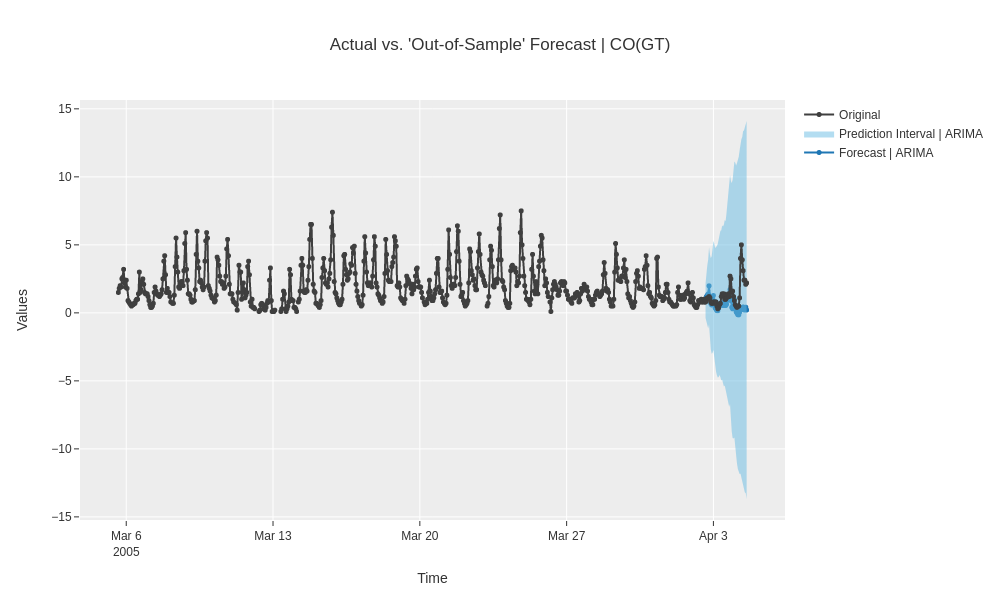

In [ ]:
exp_uni.plot_model(model_uni)

In [ ]:
exp_exo = TSForecastingExperiment()
exp_exo.setup(
    data=data, target=target, index="index", fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=plot_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(720, 11)"
5,Transformed data shape,"(720, 11)"
6,Transformed train set shape,"(672, 11)"
7,Transformed test set shape,"(48, 11)"
8,Rows with missing values,3.8%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
model_exo = exp_exo.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2005-03-27 14:00,0.2512,0.2282,0.1846,0.2455,0.1089,0.1192,0.9353
1,2005-03-29 14:00,0.2321,0.2227,0.1670,0.2378,0.1100,0.1219,0.9526
2,2005-03-31 14:00,0.2525,0.2733,0.1798,0.2872,0.1723,0.1572,0.5943
Mean,NaT,0.2453,0.2414,0.1771,0.2568,0.1304,0.1328,0.8274
SD,NaT,0.0093,0.0227,0.0074,0.0217,0.0296,0.0173,0.1650


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

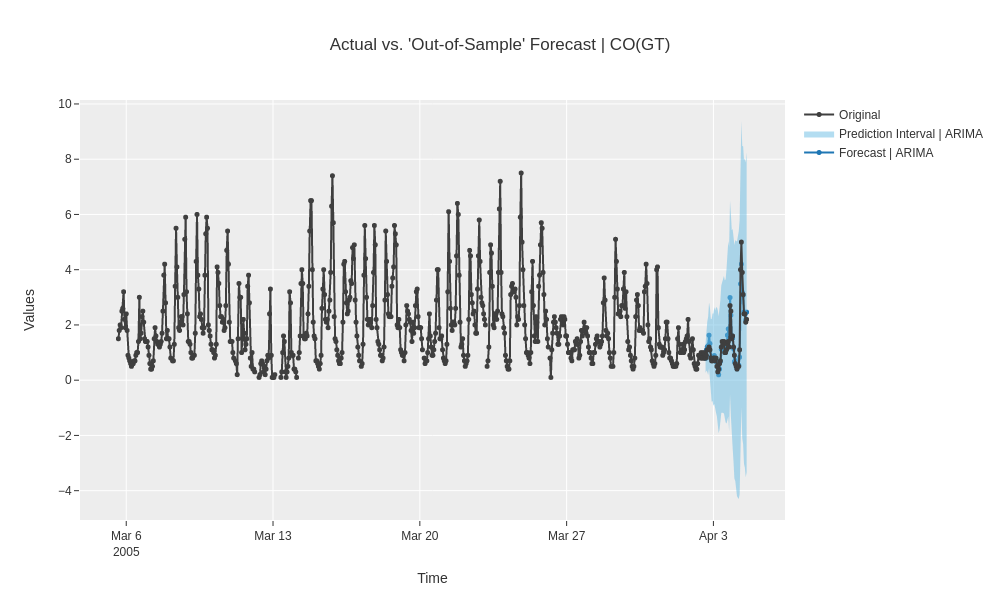

In [ ]:
exp_exo.plot_model(model_exo)

In [ ]:
final_model_exo = exp_exo.finalize_model(model_exo)

In [ ]:
def predict_wrapper(exp, model):
    try:
        exp.predict_model(model)
    except ValueError as error:
        print(error)
        exo_vars = exp.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed for predictions:\n{exo_vars}")

predict_wrapper(exp_exo, final_model_exo)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
10 exogenous variables (X) needed for predictions:
['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH']


In [ ]:
exp_slim = TSForecastingExperiment()
keep_vars = [target, "index", 'NOx(GT)', "PT08.S3(NOx)", "RH"]
data_slim = data[keep_vars]
exp_slim.setup(
    data=data_slim, target=target, index="index", fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=plot_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(720, 4)"
5,Transformed data shape,"(720, 4)"
6,Transformed train set shape,"(672, 4)"
7,Transformed test set shape,"(48, 4)"
8,Rows with missing values,3.8%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
model_slim = exp_slim.create_model("arima", order=(0,1,0), seasonal_order=(0,1,0,24))

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2005-03-27 14:00,0.5014,0.4028,0.3684,0.4334,0.2663,0.2255,0.7983
1,2005-03-29 14:00,0.2657,0.2369,0.1912,0.2529,0.1004,0.0993,0.9464
2,2005-03-31 14:00,0.3023,0.2847,0.2153,0.2992,0.2132,0.1967,0.5596
Mean,NaT,0.3565,0.3081,0.2583,0.3285,0.1933,0.1738,0.7681
SD,NaT,0.1035,0.0697,0.0784,0.0766,0.0692,0.0540,0.1593


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

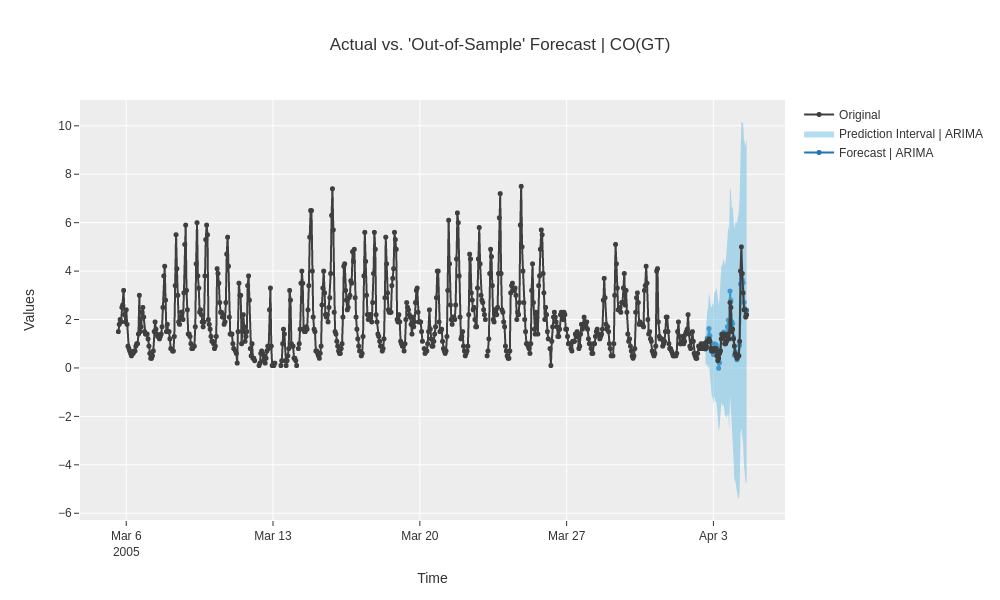

In [ ]:
exp_slim.plot_model(model_slim)

In [ ]:
final_slim_model = exp_slim.finalize_model(model_slim)

In [ ]:
_ = exp_slim.save_model(final_slim_model, "final_slim_model")

Transformation Pipeline and Model Successfully Saved


In [ ]:
predict_wrapper(exp_slim, final_slim_model)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
3 exogenous variables (X) needed for predictions:
['NOx(GT)', 'PT08.S3(NOx)', 'RH']


In [ ]:
exog_vars = ['NOx(GT)', 'PT08.S3(NOx)', 'RH']
data = data[["index"] + exog_vars]

In [ ]:
exog_exps = []
exog_models = []
for exog_var in exog_vars:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=data[["index", exog_var]], target=exog_var, index="index", fh=48,
        numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
        fig_kwargs=plot_settings, session_id=42
    )

    best_model = exog_exp.compare_models(
        sort="mase", include=["arima", "ets", "exp_smooth", "theta", "lightgbm_cds_dt"]
    )
    final_exog_model = exog_exp.finalize_model(best_model)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)

,Description,Value
0,session_id,42
1,Target,NOx(GT)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.8%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.8406,0.9158,87.3689,133.0642,0.4273,0.3443,-1.3072,1.0100
exp_smooth,Exponential Smoothing,0.8954,0.8400,93.0132,121.9760,0.4828,0.5917,-0.9311,0.2600
theta,Theta Forecaster,1.0279,0.9437,107.4620,137.6886,0.5192,0.4990,-0.4072,0.1833
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.2021,1.1033,124.6215,160.1069,0.6995,0.5078,-2.5717,5.2700
ets,ETS,1.6659,1.5724,173.0732,228.4765,0.9384,0.5574,-4.4268,1.5000


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,PT08.S3(NOx)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,1.2435,1.2056,126.5383,158.9241,0.1738,0.1695,-0.0211,0.4367
ets,ETS,1.3630,1.3141,138.7266,173.2553,0.1906,0.1879,-0.2091,1.3667
theta,Theta Forecaster,1.3716,1.3079,139.5929,172.4272,0.1909,0.1878,-0.1963,0.2667
arima,ARIMA,1.3929,1.3245,141.6775,174.6211,0.1792,0.1953,-0.3985,1.0500
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.6778,1.5491,170.7442,204.2588,0.2197,0.2541,-0.7666,3.9167


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,RH
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
theta,Theta Forecaster,1.6218,1.4765,11.3749,13.1578,0.2481,0.2286,-0.0585,0.1133
arima,ARIMA,1.8001,1.6165,12.6310,14.4108,0.2548,0.2523,-0.2695,0.3600
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.7797,2.6115,19.4667,23.2519,0.5241,0.3609,-4.8711,1.6767
exp_smooth,Exponential Smoothing,5.2972,4.7592,37.2423,42.4918,0.7188,0.9298,-10.5261,0.2367
ets,ETS,5.3235,4.7812,37.4259,42.6872,0.7228,0.9349,-10.5911,0.3767


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]

In [ ]:
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = exog_vars

In [ ]:
exp_future = TSForecastingExperiment()

In [ ]:
final_slim_model = exp_future.load_model("final_slim_model")

Transformation Pipeline and Model Successfully Loaded


<Axes: >

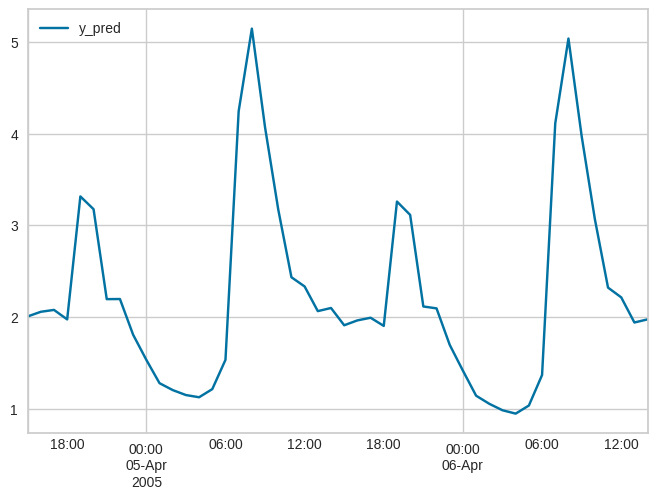

In [ ]:
future_preds = exp_future.predict_model(final_slim_model, X=future_exog)
future_preds.plot()